
# Tacotron2 ile Text-to-Speech 



In [1]:
import IPython
import matplotlib
import matplotlib.pyplot as plt

## Genel Bakış

Önceden eğitilmiş Tacotron2 'yi Torchaudio'dan kullanacağız.

Uygulamamız gereken adımlar şu şekilde olacak.

1. Text preprocessing

  İlk olarak, giriş metni bir semboller listesine kodlanır.

2. Spectrogram generation

  Kodlanmış metinden bir spektrogram oluşturulur. ``Tacotron2`` kullanacağımızı belirtmiştik. 

3. Time-domain conversion

   Son adım, spektrogramı dalga biçimine dönüştürmektir. Spektrogramdan konuşma üretme işlemine Vocoder da denir.Bu eğitimde, üç farklı ses kodlayıcı kullanılmıştır,
   `~torchaudio.models.WaveRNN`,
   `~torchaudio.transforms.GriffinLim`, ve
   [Nvidia's WaveGlow](https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/).


Aşağıdaki şekil tüm süreci göstermektedir.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/tacotron2_tts_pipeline.png">

İlgili tüm bileşenler`torchaudio.pipelines.Tacotron2TTSBundle` de mevcuttur.


## Hazırlık

Öncelikle gerekli paketleri import edeceğiz. `DeepPhonemizer` paketi colab de bulunmadığından dolayı pip install ile indirelim.



In [ ]:
%%bash
pip3 install deep_phonemizer

In [3]:
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.13.1+cu116
0.13.1+cu116
cuda


## Text Processing




### Karakter Tabanlı Kodlama

Önceden eğitilmiş Tacotron2 modeli belirli bir sembol seti bekler.
İlk olarak, sembol kümesini tanımlarız. Örneğin,
``'_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz''' şeklinde.
Sonrasında ise mapping yapacağız. Giriş metnin her karakterini tablodaki ilgili dizinde bulunan rakam ile eşleştireceğiz. Tabloda olmayan semboller yok sayılır.




In [4]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


Yukarıda belirtildiği gibi, sembol tablosu ve indeksler eşleşmelidir.
Önceden eğitilmiş Tacotron2 modelinin beklentisi budur..



In [5]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


``processor`` nesnesi girdi olarak bir metin veya metin listesi alır. Bir metin listesi sağlandığında döndürülen `lengths` değişkeni çıktıda işlenen her tokenin geçerliği uzunluğunu temsil eder.


In [6]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


### Phoneme tabanlı kodlama 

Karakter tabanlı kodlamaya benzer, ancak
fonemlere dayalı bir sembol tablosu ve bir G2P (Grapheme-to-Phoneme) kullanır.

Karakter tabanlı kodlamaya benzer şekilde, kodlama işlemi
Önceden eğitilmiş bir Tacotron2 modelinin üzerinde eğitildiğiyle eşleşmesi bekleniyor.
``torchaudio``, süreci oluşturmak için bir arayüze sahiptir.

``DeepPhonemizer`` paketi kullanılarak bir G2P modeli oluşturulur ve
``DeepPhonemizer`` yazarı tarafından yayınlanan önceden eğitilmiş ağırlıklar
kullanılmıştır.




In [7]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

  0%|          | 0.00/63.6M [00:00<?, ?B/s]

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


Tensor şeklindeki çıktının karakter tabanlı kodlama çıktısından farklı olduğunu görmeniz gerekir..




In [8]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


## Spektrogram Üretimi

``Tacotron2``, spektrogram oluşturmak için kullandığımız modeldir.[makalesi burada](https://arxiv.org/abs/1712.05884).

Önceden eğitilmiş ağırlıkla bir Tacotron2 modelini başlatmak kolaydır,
ancak, Tacotron2 modellerine yapılan girdilerin işlenmesi gerektiğini unutmayın.

`torchaudio.pipelines.Tacotron2TTSBundle` kullanarak bu işlemi sade bir şekilde yapabiliriz.
Daha fazlası için detaylıca kontrol edebilirsiniz.




Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

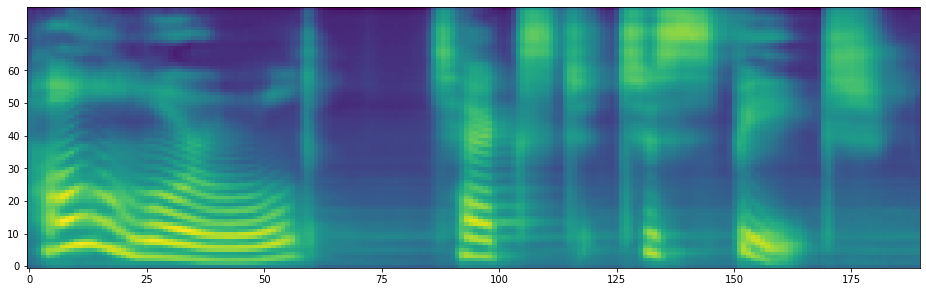

In [9]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

``Tacotron2.infer`` yönteminin çok terimli örnekleme gerçekleştirdiğini unutmayın,
bu nedenle, spektrogram oluşturma işlemi rastgeleliğe neden olur.




torch.Size([80, 191])
torch.Size([80, 171])
torch.Size([80, 182])


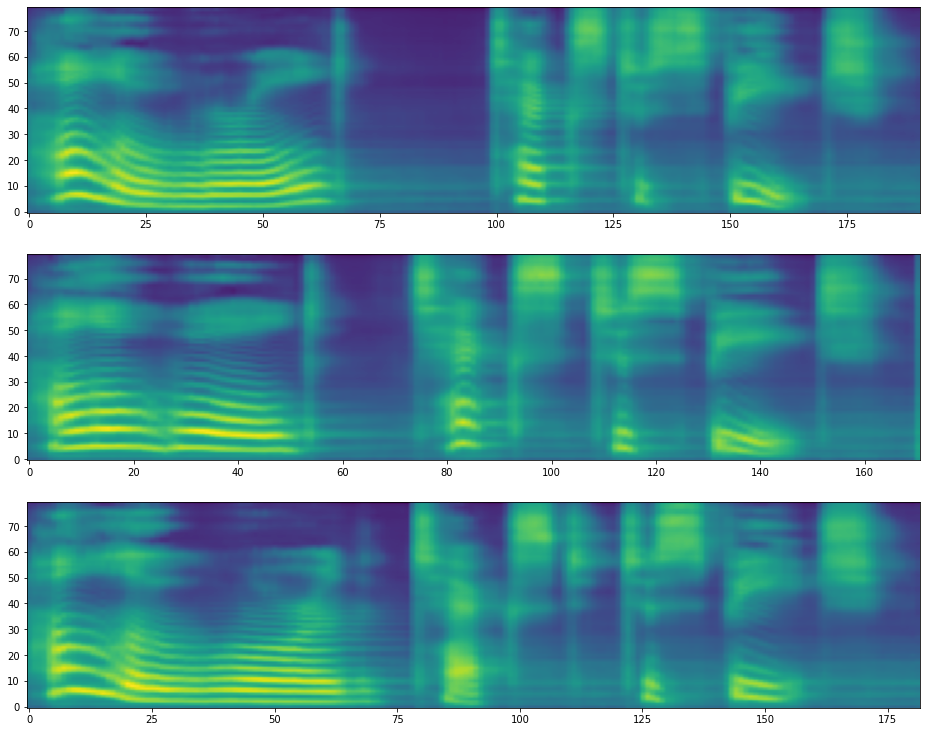

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(16, 4.3 * 3))
for i in range(3):
    with torch.inference_mode():
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    print(spec[0].shape)
    ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
plt.show()

## Waveform Üretimi

Spektrogram oluşturulduktan sonra, son işlem,
spektrogramdan dalga formu.

``torchaudio``  ``GriffinLim`` ve ``WaveRNN`` tabanlı ses kodlayacıları sağlar.




### WaveRNN



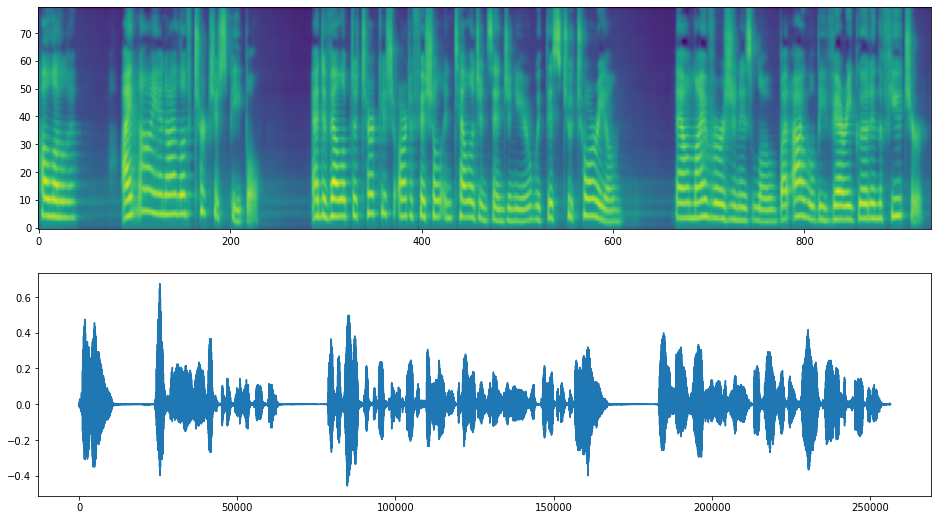

In [19]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "hello, i am ai and i love turkish people. I developed a Turkish artificial intelligence engineer with this tutorial. Now my version is low. But I will be very good in the future."

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)

### Griffin-Lim


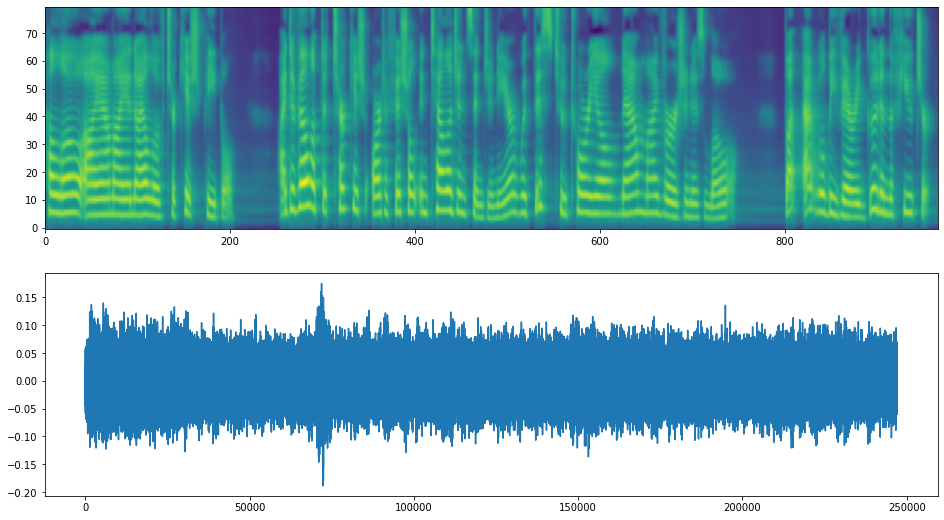

In [20]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)

### Waveglow

Waveglow, Nvidia tarafından yayınlanan bir ses kodlayıcıdır. Önceden eğitilmiş ağırlıklar
Torch Hub'da yayınlandı. ``torch.hub`` kullanılarak model başlatılabilir.




Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


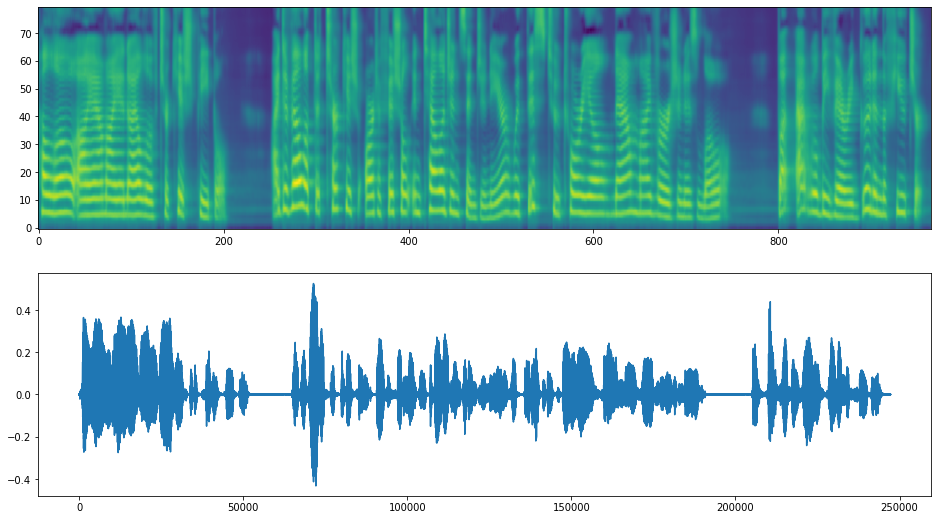

In [21]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=22050)